For reference use examples provided by Kwakkel (2018): https://github.com/quaquel/pyNetLogo/blob/55431ddb3c75c5dec41855fca874fbc7e9034ce1/examples/SALib_sequential.ipynb
Make sure when implementing the code, that the file directories where the model is stored is correct.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pyNetLogo

#Import the sampling and analysis modules for a Sobol variance-based sensitivity analysis
from SALib.sample import saltelli
from SALib.analyze import sobol

In [19]:
problem = { 
  'num_vars': 2,
  'names': ['fac-observability',
            'fac-eff-trust-others'], 
  'bounds': [[0.025, 0.075],
             [0.025, 0.075] 
            ]
}


In [3]:
import os

netlogo = pyNetLogo.NetLogoLink(gui=False)
model_file = os.path.join(netlogo.netlogo_home, 'models/Model 01-02.1 final.nlogo')
netlogo.load_model(model_file)

In [4]:
n = 100
param_values = saltelli.sample(problem, n, calc_second_order=True)

/var/folders/ql/w63wxz_17xnd0ryv6kshxn380000gn/T/ipykernel_6098/2042170087.py:2: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, n, calc_second_order=True)
/Users/rvdpn/opt/anaconda3/envs/netlogo-env/lib/python3.10/site-packages/SALib/sample/saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (100) is equal to `2^n`.
        
  warnings.warn(msg)


In [5]:
param_values.shape

(600, 2)

In [6]:
results = pd.DataFrame(columns=['Avg intent'])
results

,Avg intent


In [7]:
import time

t0 = time.time()

for run in range(param_values.shape[0]):
    
    #Set the input parameters
    for i, name in enumerate(problem['names']):
        if name == 'random-seed':
            #The NetLogo random seed requires a different syntax
            netlogo.command('random-seed {}'.format(param_values[run,i]))
        else:
            #Otherwise, assume the input parameters are global variables
            netlogo.command('set {0} {1}'.format(name, param_values[run,i]))
            
    netlogo.command('setup')
    #Run for 100 ticks and return the number of sheep and wolf agents at each time step
    counts = netlogo.repeat_report(['mean [intent] of households'], 520, include_t0=False)
    
    #For each run, save the mean value of the agent counts over time]
    results.loc[run, 'Avg intent'] = counts['mean [intent] of households'].values.mean()
    
elapsed = time.time()-t0 #Elapsed runtime in seconds

In [8]:
results

,Avg intent
0,0.023939
1,0.014751
2,0.046438
3,0.034819
4,0.024897
...,...
595,0.058197
596,0.022453
597,0.036998
598,0.043214


In [16]:
results.to_csv('Sobol_sequential_hh_intent.csv')

In [20]:
results = pd.read_csv('Sobol_sequential_hh_intent.csv', header=0, index_col=0)

In [11]:
elapsed

15146.4085419178

In [21]:
Si = sobol.analyze(problem, results['Avg intent'].values, calc_second_order=True, print_to_console=False)

In [22]:
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

In [23]:
Si_df

,ST,ST_conf,S1,S1_conf
fac-observability,0.899183,0.267719,-0.041500,0.220150
fac-eff-trust-others,1.061465,0.220647,-0.173953,0.268863


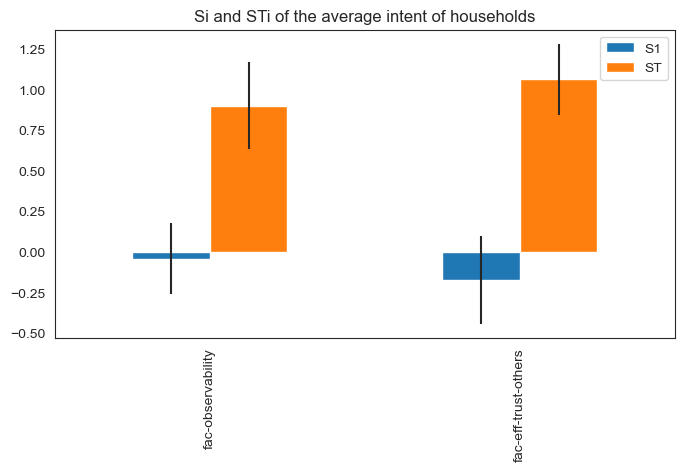

In [26]:
sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
ax.set_title('Si and STi of the average intent of households')
fig.set_size_inches(8,4)

plt.savefig('Si and STi of the average intent of households', bbox_inches='tight')


plt.show()